In [1]:
# script that generates all plots for integration of networks with tissue expression data from GTEx
import config
#import condition_network_classes_v6

import numpy, pandas, igraph
import math, copy, pickle, scipy.stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%matplotlib inline

from utils import load_protein_coding_genome, load_id_map


figure_path = '../figures/'


In [2]:
# function that returns two lists, with the fraction of observed TiP genes in the network and std error 
# of proportion
def get_network_TiP_coverage(maxTiP_series,space,network,ori):

    GTEx_genes = set(maxTiP_series.index.tolist())
    spaceG = space.intersection(GTEx_genes)
    fracs = []
    errors = []
    if ori == 'both':
        nw_nodes = set(network.vs['name']).intersection(spaceG)
    elif ori == 'DB':
        outdegree_seq = network.outdegree()
        indices = list(filter(lambda v: outdegree_seq[v] > 0,range(len(outdegree_seq))))
        nw_nodes = set([network.vs[i]['name'] for i in indices]).intersection(spaceG)
    else:
        indegree_seq = network.indegree()
        indices = list(filter(lambda v: indegree_seq[v] > 0,range(len(indegree_seq))))
        nw_nodes = set([network.vs[i]['name'] for i in indices]).intersection(spaceG)

    exp_frac = len(nw_nodes)/float(len(spaceG))
    
    for i in range(maxTiP_series[maxTiP_series<=8].shape[0]):
        TiP_genes = set(maxTiP_series.index[i:].tolist()).intersection(spaceG)
        if len(TiP_genes) > 0:
            obs_frac = len(TiP_genes.intersection(nw_nodes))/float(len(TiP_genes))
            frac = obs_frac/exp_frac
            fracs.append(frac)
            if obs_frac > 0:
                errors.append((math.sqrt(obs_frac*(1-obs_frac)/len(TiP_genes)))/exp_frac)
            else:
                errors.append(0)
        else:
            break
            
    return fracs, errors

# returns a tissue network for the given source network and tissue
def get_CSN_for_tissue_and_source_network(name_source_network,tissue):

    file1 = open(config.analysis_path + name_source_network + '/GTExv6_' + name_source_network + '_CSNs.txt','r')
    entries = file1.readlines()
    file1.close()
    tissues = entries[0][:-1].split('\t')
    edge_list = []
    for line in entries[1:]:
        tab_list = str.split(line[:-1],'\t')
        gene_a = tab_list[0]
        gene_b = tab_list[1]
        frac_samples = float(tab_list[tissues.index(tissue)])
        if frac_samples > config.edge_expr_cutoff:
            edge_list.append((gene_a,gene_b))
    nodes = set()
    for edge in edge_list:
        nodes.add(edge[0])
        nodes.add(edge[1])
    CSN = igraph.Graph()
    CSN.add_vertices(list(nodes))
    CSN.add_edges(edge_list)

    return CSN


In [3]:
# read in the GTEx and TiP value data
# the GTEx data contains testis, the TiP data does not
TiPmatrix = pandas.read_csv('../data/processed/Supplementary Table 22.txt', sep='\t').set_index('Ensembl_gene_id')
GTEx = pandas.read_csv('../data/processed/Supplementary Table 23.txt', sep='\t').set_index('Ensembl_gene_id')
GTEx = GTEx.drop(columns=['testis'])
GTEx_tissues = TiPmatrix.columns
for tissue in GTEx_tissues:
    TiPmatrix.loc[TiPmatrix.index.isin(GTEx.index[GTEx[tissue]<=5]),[tissue]] = numpy.NaN
    
maxTiP_series = TiPmatrix.max(axis=1,numeric_only=True)
maxTiP_series.dropna(inplace=True)
maxTiP_series.sort_values(inplace=True)
GTEx_genes = set(maxTiP_series.index.tolist())


In [7]:
# load all the tissue-filtered collapsed networks
network_names = ['Lit-BM-17','BioPlex','QUBIC','CoFrac','HI-I-05','HI-II-14','HI-III']
network_colors = [(60/255, 134/255, 184/255),'#e6550d','#fd8d3c','#fdbe85','pink','orchid',(155/255, 97/255, 153/255)]

networks = []
for network_name in network_names:
    pickle_file = config.analysis_path + network_name + '/GTExv6_collapsed_CSN_' + network_name + '_no_testis.pickle'
    networks.append(pickle.load(open(pickle_file,'rb')))


In [10]:
obs_frac_networks = []
err_networks = []
for network in networks:
    fracs,errors = get_network_TiP_coverage(maxTiP_series,GTEx_genes,network,'both')
    obs_frac_networks.append(fracs)
    err_networks.append(errors)
    
file1 = open(config.global_path + 'network_data.pickle','wb')
pickle.dump([obs_frac_networks,err_networks],file1)
file1.close()


FileNotFoundError: [Errno 2] No such file or directory: '../data/katjas_data/GTEx/analysis_GTExV6_2018_frozen/global/network_data.pickle'

In [ ]:
file1 = open(config.global_path + 'network_data.pickle','rb')
obs_frac_networks,err_networks = pickle.load(file1)
file1.close()


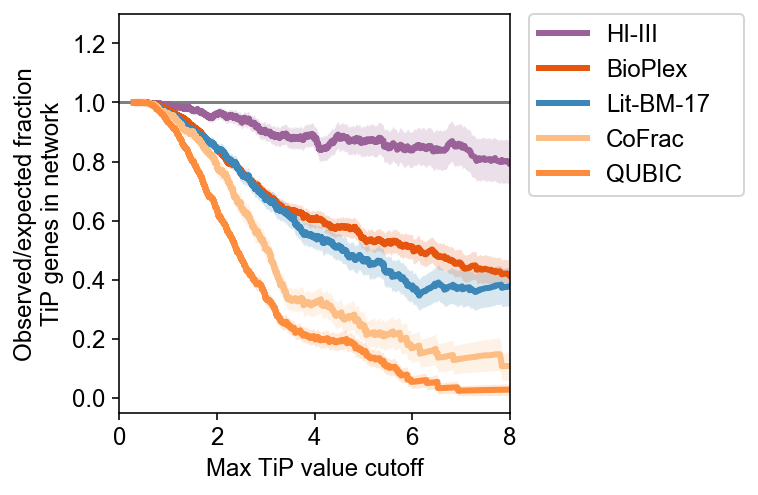

In [11]:
# plot all networks together in one plot
plt.figure(figsize=(4,3.5))

sel_network_names = ['HI-III','BioPlex','Lit-BM-17','CoFrac','QUBIC']
plt.plot([-1,9],[1,1],marker='',linestyle='-',color='grey')
for network_name in sel_network_names:
    index = network_names.index(network_name)
    plt.plot(maxTiP_series[maxTiP_series<=8],obs_frac_networks[index],
             color=network_colors[index],marker='',linestyle='-',linewidth=3,label=network_name)
    plt.fill_between(maxTiP_series[maxTiP_series<=8],
                     [f-e for f,e in zip(obs_frac_networks[index],err_networks[index])],
                     [f+e for f,e in zip(obs_frac_networks[index],err_networks[index])],
                     alpha=0.2,color=network_colors[index],linewidth=0)
plt.ylabel('Observed/expected fraction\nTiP genes in network',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylim([-0.05,1.3])
plt.xlim([0,8])
plt.xlabel('Max TiP value cutoff',fontsize=12)

lgd = plt.legend(bbox_to_anchor=(1.05, 1,0.55,0),loc=2,ncol=1,mode="expand",borderaxespad=0.,fontsize=12)
plt.tight_layout()

outfile = figure_path + 'network_bias_all_one_plot_longer_axis'
plt.savefig(outfile + '.pdf',format='pdf',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(outfile + '.png',format='png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


In [14]:
(maxTiP_series >= 8).sum()

233

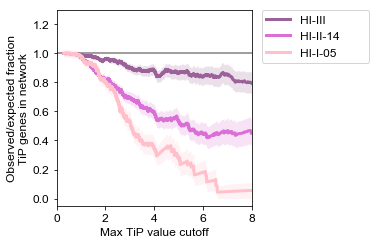

In [9]:
# plot all networks together in one plot
plt.figure(figsize=(4,3.5))

sel_network_names = ['HI-III','HI-II-14','HI-I-05']
plt.plot([-1,9],[1,1],marker='',linestyle='-',color='grey')
for network_name in sel_network_names:
    index = network_names.index(network_name)
    plt.plot(maxTiP_series[maxTiP_series<=8],obs_frac_networks[index],
             color=network_colors[index],marker='',linestyle='-',linewidth=3,label=network_name)
    plt.fill_between(maxTiP_series[maxTiP_series<=8],
                     [f-e for f,e in zip(obs_frac_networks[index],err_networks[index])],
                     [f+e for f,e in zip(obs_frac_networks[index],err_networks[index])],
                     alpha=0.2,color=network_colors[index],linewidth=0)
plt.ylabel('Observed/expected fraction\nTiP genes in network',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylim([-0.05,1.3])
plt.xlim([0,8])
plt.xlabel('Max TiP value cutoff',fontsize=12)

lgd = plt.legend(bbox_to_anchor=(1.05, 1,0.55,0),loc=2,ncol=1,mode="expand",borderaxespad=0.,fontsize=12)
plt.tight_layout()

outfile = figure_path + 'network_bias_CCSB_one_plot_longer_axis'
plt.savefig(outfile + '.pdf',format='pdf',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(outfile + '.png',format='png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


In [19]:
# plot stats on integrating HuRI with GTEx
# get the PC genome

PCgenome = load_protein_coding_genome()

# get the protein-coding genome that is expressed in GTEx
GTEx_PC_genome = set(GTEx.index[GTEx.max(axis=1)>5])
print(len(GTEx_PC_genome))

# read in the PC genome filtered and GTEx co-expressed PPI networks
network_names = ['HI-III','CoFrac','QUBIC','BioPlex','Lit-BM-17']
collapsed_CSNs = []
for network_name in network_names:
    pickle_file = config.analysis_path + network_name + '/GTExv6_collapsed_CSN_' + network_name + '.pickle'
    collapsed_CSNs.append(pickle.load(open(pickle_file,'rb')))

# load standard networks
networks = config.load_networks()


16695


In [20]:
num_PPI_PC_networks = []
num_PPI_expr_networks = []
num_PPI_coexpr_networks = []
for n,network_name in enumerate(network_names):
    nw = networks[network_name]
    num_PPI_PC_networks.append(len(nw.es))
    nodes = set(nw.vs['name'])
    pc_gtex_nodes = nodes.intersection(GTEx_PC_genome)
    expr_nw = condition_network_classes_v6.get_linked_subgraph(nw,pc_gtex_nodes)
    num_PPI_expr_networks.append(len(expr_nw.es))
    num_PPI_coexpr_networks.append(len(collapsed_CSNs[n].es))

In [6]:
# plot stats for a given network on integration with GTEx
network_name = 'HI-III'
CSNs = {}
for c,condition in enumerate(GTEx.columns):
    CSNs[condition] = get_CSN_for_tissue_and_source_network(network_name,condition)

In [9]:
# get n values
'; '.join([(t.capitalize().replace('_', ' ') + ': ' + str(len(g.es))) for t, g in CSNs.items()])

'Adipose subcutaneous: 24622; Adipose visceral omentum: 24817; Adrenal gland: 24363; Artery aorta: 23980; Artery coronary: 24718; Artery tibial: 23617; Brain-0: 25359; Brain-1: 24345; Brain-2: 25238; Breast mammary tissue: 26156; Colon sigmoid: 24783; Colon transverse: 25754; Esophagus gastroesophageal junction: 24591; Esophagus mucosa: 25677; Esophagus muscularis: 24474; Heart atrial appendage: 24411; Heart left ventricle: 23120; Kidney cortex: 25628; Liver: 23000; Lung: 26178; Minor salivary gland: 26038; Muscle skeletal: 22397; Nerve tibial: 25447; Ovary: 24253; Pancreas: 24692; Pituitary: 26738; Prostate: 25830; Skin: 26714; Small intestine terminal ileum: 26025; Spleen: 24762; Stomach: 25001; Testis: 30217; Thyroid: 25689; Uterus: 24948; Vagina: 26119; Whole blood: 19960'

In [11]:
max([len(g.es) for g in CSNs.values()])

30217

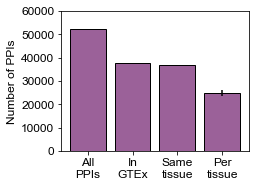

Percentage of GTEx network that is co-expr: 0.972826374556808
[52088, 37794, 36767, 24841.257142857143]


In [21]:
network_name = 'HI-III'
values = []
labels = ['All\nPPIs','In\nGTEx','Same\ntissue','Per\ntissue']
values.append(num_PPI_PC_networks[network_names.index(network_name)])
values.append(num_PPI_expr_networks[network_names.index(network_name)])
values.append(num_PPI_coexpr_networks[network_names.index(network_name)])
values.append(numpy.mean([len(CSN.es) for CSN in CSNs.values()]))
values_yerr = [0 for i in range(len(values)-1)] + [numpy.std([len(CSN.es) for CSN in CSNs.values()])]

plt.figure(figsize=(3.7,2.7))
plt.bar(range(len(values)),values,yerr=values_yerr,width=0.8,color=(155/255, 97/255, 153/255),edgecolor='black',ecolor='black',align='center',label=network_name)
plt.ylabel('Number of PPIs',fontsize=12)
plt.xticks(range(len(values)),labels,fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0,60000])
#plt.legend(loc='best')
plt.tight_layout()
outfile = figure_path + '/GTExv6_' + network_name + '_interactome_filtering_stats'
plt.savefig(outfile + '.pdf',format='pdf',dpi=300)
plt.savefig(outfile + '.png',format='png',dpi=300)
plt.show()

print('Percentage of GTEx network that is co-expr:', values[2]/float(values[1]))
print(values)


In [22]:
# plot the fraction of TiP genes and TiP edges in the genome, and Lit-BM and HI-III respectively 
# in a continuous way

sel_network_names = ['Lit-BM-17','HI-III']
colors = [(60/255, 134/255, 184/255),(155/255, 97/255, 153/255)]

networks = []
for network_name in sel_network_names:
    pickle_file = config.analysis_path + network_name + '/GTExv6_collapsed_CSN_' + network_name + '_no_testis.pickle'
    networks.append(pickle.load(open(pickle_file,'rb')))

for nw in networks:
    min_TiP = []
    for edge in nw.es:
        min_TiP.append(max(maxTiP_series[nw.vs[edge.source]['name']],maxTiP_series[nw.vs[edge.target]['name']]))
    nw.es['min_TiP'] = min_TiP

# calculate the fraction of TiP genes for increasing TiP cutoffs
# calculate the fraction of the edges that involve a TiP gene for increasing TiP cutoffs
frac_TiPs = []
err_TiPs = []
network_fracs = [[] for i in range(len(sel_network_names))]
network_errors = [[] for i in range(len(sel_network_names))]
new_values = [network.es['min_TiP'] for network in networks]
for i in range(maxTiP_series[maxTiP_series<=8].shape[0]):
    if i % 1000 == 0:
        print(i)
    genome_size = float(maxTiP_series.shape[0])
    frac_TiP = (genome_size-(i+1))/genome_size
    frac_TiPs.append(frac_TiP)
    err_TiPs.append(numpy.sqrt(frac_TiP*(1-frac_TiP)/genome_size))
    TiP_value = maxTiP_series[i]
    for n,sel_network_name in enumerate(sel_network_names):
        # determine the number PPIs involving a TiP gene and the fraction of those in the network
        new_values[n] = list(filter(lambda v: v >= TiP_value,new_values[n]))
        frac = len(new_values[n])/float(len(networks[n].es))
        network_fracs[n].append(frac)
        network_errors[n].append(numpy.sqrt(frac*(1-frac)/float(len(networks[n].es))))


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000


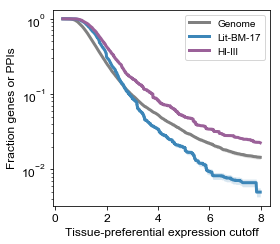

In [27]:
plt.figure(figsize=(4,3.5))

plt.plot(maxTiP_series[maxTiP_series<=8],frac_TiPs,color='grey',marker='',linestyle='-',linewidth=3,label='Genome')
plt.fill_between(maxTiP_series[maxTiP_series<=8],
                 [f-e for f,e in zip(frac_TiPs,err_TiPs)],
                 [f+e for f,e in zip(frac_TiPs,err_TiPs)],
                 alpha=0.2,color='grey',linewidth=0)
for n,network_name in enumerate(sel_network_names):
    plt.plot(maxTiP_series[maxTiP_series<=8],network_fracs[n],color=colors[n],marker='',linestyle='-',linewidth=3,label=network_name)
    plt.fill_between(maxTiP_series[maxTiP_series<=8],
                     [f-e for f,e in zip(network_fracs[n],network_errors[n])],
                     [f+e for f,e in zip(network_fracs[n],network_errors[n])],
                     alpha=0.2,color=colors[n],linewidth=0)
plt.ylabel('Fraction genes or PPIs',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax = plt.gca()
ax.set_yscale('log', basey=10, nonposy='clip')
plt.xlabel('Tissue-preferential expression cutoff',fontsize=12)
plt.legend(loc='upper right',fontsize=10)
plt.tight_layout()
outfile = figure_path + 'collapsed_CSN_HI_Lit_genome_frac_TiP_continuous'
plt.savefig(outfile + '.pdf',format='pdf',dpi=300)
plt.savefig(outfile + '.png',format='png',dpi=300)
plt.show()


In [33]:
# get the order of the tissues as for the TiP closeness plot
infile = '{}{}/GTExv6_NT_{}_TiPgenes_{}_{}_closeness_test_summary.txt'.\
        format(config.analysis_path,network_name,network_name,'2.0','nl')
df = pandas.read_table(infile,index_col=0)

df.sort_values(['condition'],inplace=True)
df_cut = df.loc[df['num_TiP_genes_in_CSN']>=5,]
tissue_order = df_cut.index.tolist()
print(tissue_order)

# load a mapping between ensembl gene ID and gene symbol
id_symbol_dict = (load_id_map('ensembl_gene_id', 'hgnc_symbol')
                  .drop_duplicates('ensembl_gene_id')
                  .set_index('ensembl_gene_id')['hgnc_symbol']
                  .to_dict())

TiP_cutoff = 2
num_TiP_nw_list = []
num_TiP_epith_list = []
num_TiP_genes_wTiPpartner_list = []
num_TiP_epith_wTiPpartner_list = []
for tissue in tissue_order:
    TiPgenes = set(TiPmatrix.loc[TiPmatrix[tissue]>=2,].index.tolist())
    CSN = CSNs[tissue]
    nw_nodes = set(CSN.vs['name'])
    TiP_nw_genes = nw_nodes.intersection(TiPgenes)
    TiP_genes_wTiPpartner = set()
    for gene_id in TiP_nw_genes:
        n_indices = CSN.neighbors(gene_id)
        n_gene_ids = set([CSN.vs[i]['name'] for i in n_indices])
        if len(n_gene_ids.intersection(TiP_nw_genes)) > 0:
            TiP_genes_wTiPpartner.add(gene_id)
    epith_TiP_nw_genes = set()
    epith_TiP_nw_genes_wTiPpartner = set()
    for gene_id in TiP_nw_genes:
        if gene_id in id_symbol_dict:
            symbol = id_symbol_dict[gene_id]
        if symbol[:3] == 'KRT' or symbol[:3] == 'LCE':
            epith_TiP_nw_genes.add(gene_id)
            if gene_id in TiP_genes_wTiPpartner:
                epith_TiP_nw_genes_wTiPpartner.add(gene_id)
    num_TiP_nw_list.append(len(TiP_nw_genes))
    num_TiP_epith_list.append(len(epith_TiP_nw_genes))
    num_TiP_genes_wTiPpartner_list.append(len(TiP_genes_wTiPpartner))
    num_TiP_epith_wTiPpartner_list.append(len(epith_TiP_nw_genes_wTiPpartner))

['adrenal_gland', 'artery_aorta', 'artery_tibial', 'brain-0', 'brain-1', 'brain-2', 'breast_mammary_tissue', 'colon_sigmoid', 'colon_transverse', 'esophagus_mucosa', 'heart_atrial_appendage', 'heart_left_ventricle', 'kidney_cortex', 'liver', 'lung', 'minor_salivary_gland', 'muscle_skeletal', 'nerve_tibial', 'ovary', 'pancreas', 'pituitary', 'prostate', 'skin', 'small_intestine_terminal_ileum', 'spleen', 'stomach', 'thyroid', 'vagina', 'whole_blood']


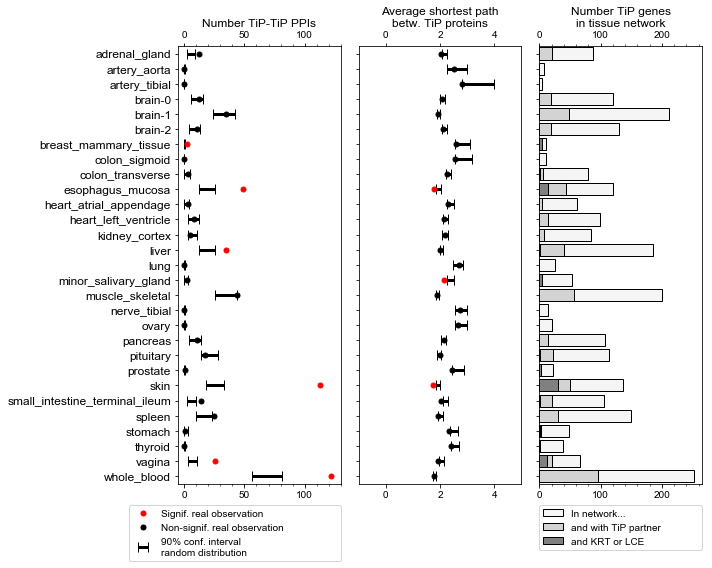

In [38]:
# plot num PPIs and avg shortest path results together and KRT/LCE barplot
TiP_cut = '2.0'

plt.figure(figsize=(10,8))

plt.subplot(1,3,1)

cl_type = 'nl'
pval_col = 'p_value_greater'
infile = '{}{}/GTExv6_NT_{}_TiPgenes_{}_{}_closeness_test_summary.txt'.\
        format(config.analysis_path,network_name,network_name,TiP_cut,cl_type)
df = pandas.read_table(infile,index_col=0)
ref_df = df.sort_values(['condition'],inplace=False)
ref_df = ref_df.loc[ref_df['num_TiP_genes_in_CSN'] >= 5,]

ref_df['lower_err'] = ref_df['median_rand_obs'] - ref_df['5th_perc_rand_obs']
ref_df['upper_err'] = ref_df['95_perc_rand_obs'] - ref_df['median_rand_obs']
plt.errorbar(ref_df['median_rand_obs'],range(ref_df.shape[0]),
             xerr=list(ref_df[['lower_err','upper_err']].transpose().values),
             marker='',linestyle='',elinewidth=3,ecolor='black',capsize=5,label='90% conf. interval\nrandom distribution')
ref_df['counter'] = range(ref_df.shape[0])
ref_df_signif = ref_df.loc[ref_df[pval_col]<=0.05/35,]
plt.plot(ref_df_signif['real_obs'],ref_df_signif['counter'],
         marker='.',linestyle='',markersize=10,color='red',label='Signif. real observation')
ref_df_signif = ref_df.loc[ref_df[pval_col]>0.05/35,]
plt.plot(ref_df_signif['real_obs'],ref_df_signif['counter'],
         marker='.',linestyle='',markersize=10,color='black',label='Non-signif. real observation')
plt.ylim([-0.5,len(tissue_order)-0.5])
ax = plt.gca()
ax.invert_yaxis()
plt.yticks(range(ref_df.shape[0]),ref_df.index.tolist(),fontsize=12)
ax.xaxis.set_label_position('top')
plt.xlabel('Number TiP-TiP PPIs',fontsize=12)
minorLocator = matplotlib.ticker.MultipleLocator(10)
ax.xaxis.set_minor_locator(minorLocator)
ax.tick_params(axis='x',which='minor',labeltop=True,labelbottom=True,bottom=True,top=True)
ax.tick_params(axis='x',which='major',labeltop=True,labelbottom=True,bottom=True,top=True)
plt.xlim([-5,130])
lgd = plt.legend(bbox_to_anchor=(-0.3,-0.04,1.3,-0.01),loc=1,ncol=1,mode="expand",borderaxespad=0.,fontsize=10)

plt.subplot(1,3,2)

cl_type = 'asp'
pval_col = 'p_value_smaller'
infile = '{}{}/GTExv6_NT_{}_TiPgenes_{}_{}_closeness_test_summary.txt'.\
        format(config.analysis_path,network_name,network_name,TiP_cut,cl_type)
df = pandas.read_table(infile,index_col=0)
ref_df = df.sort_values(['condition'],inplace=False)
ref_df = ref_df.loc[ref_df['num_TiP_genes_in_CSN'] >= 5,]

ref_df['lower_err'] = ref_df['median_rand_obs'] - ref_df['5th_perc_rand_obs']
ref_df['upper_err'] = ref_df['95_perc_rand_obs'] - ref_df['median_rand_obs']
plt.errorbar(ref_df['median_rand_obs'],range(ref_df.shape[0]),
             xerr=list(ref_df[['lower_err','upper_err']].transpose().values),
             marker='',linestyle='',elinewidth=3,ecolor='black',capsize=5)
ref_df['counter'] = range(ref_df.shape[0])
ref_df_signif = ref_df.loc[ref_df[pval_col]<=0.05/35,]
plt.plot(ref_df_signif['real_obs'],ref_df_signif['counter'],
         marker='.',linestyle='',markersize=10,color='red')
ref_df_signif = ref_df.loc[ref_df[pval_col]>0.05/35,]
plt.plot(ref_df_signif['real_obs'],ref_df_signif['counter'],
         marker='.',linestyle='',markersize=10,color='black')
plt.ylim([-0.5,len(tissue_order)-0.5])
ax = plt.gca()
ax.invert_yaxis()
plt.yticks(range(len(tissue_order)),['' for i in range(len(tissue_order))])
ax.xaxis.set_label_position('top')
plt.xlabel('Average shortest path\nbetw. TiP proteins',fontsize=12)
ax.tick_params(axis='x',which='minor',labeltop=True,labelbottom=True,bottom=True,top=True)
ax.tick_params(axis='x',which='major',labeltop=True,labelbottom=True,bottom=True,top=True)
plt.xlim([-1,5])

plt.subplot(1,3,3)

plt.barh(range(len(tissue_order)),num_TiP_nw_list[::-1],height=0.8,color='whitesmoke',edgecolor='black',label='In network...')
plt.barh(range(len(tissue_order)),num_TiP_genes_wTiPpartner_list[::-1],height=0.8,color='lightgrey',edgecolor='black',label='and with TiP partner')
plt.barh(range(len(tissue_order)),num_TiP_epith_list[::-1],height=0.8,color='grey',edgecolor='black',label='and KRT or LCE')
ax = plt.gca()
plt.ylim([-0.5,len(tissue_order)-0.5])
plt.yticks(range(len(tissue_order)),['' for i in range(len(tissue_order))])
ax.xaxis.set_label_position('top')
plt.xlabel('Number TiP genes\nin tissue network',fontsize=12)
minorLocator = matplotlib.ticker.MultipleLocator(20)
ax.xaxis.set_minor_locator(minorLocator)
ax.tick_params(axis='x',which='minor',labeltop=True,labelbottom=True,bottom=True,top=True)
ax.tick_params(axis='x',which='major',labeltop=True,labelbottom=True,bottom=True,top=True)
lgd = plt.legend(bbox_to_anchor=(0,-0.04,1,-0.01),loc=1,ncol=1,mode="expand",borderaxespad=0.,fontsize=10)

plt.tight_layout()
outfile = '{}/GTExv6_{}_NT_TiPgenes_{}_closeness_test_summary'.\
        format(figure_path,network_name,TiP_cut)
plt.savefig(outfile + '.pdf',format='pdf',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(outfile + '.png',format='png',dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [40]:
# calculate the number of TiP gene-mediated PPIs in every tissue network,
# the number of TiP-TiP PPIs
# and the number of TiP-TiP PPIs linking KRTs and LCEs with each other, respectively
num_TiP_PPI_list = []
num_TiP_TiP_PPI_list = []
num_KL_KL_PPI_list = []
for tissue in tissue_order:
    TiPgenes = set(TiPmatrix.loc[TiPmatrix[tissue]>=2,].index.tolist())
    CSN = CSNs[tissue]
    nw_nodes = set(CSN.vs['name'])
    TiP_nw_genes = nw_nodes.intersection(TiPgenes)
    TiP_PPIs = set()
    for gene_id in TiP_nw_genes:
        n_indices = CSN.neighbors(gene_id)
        n_gene_ids = set([CSN.vs[i]['name'] for i in n_indices])
        PPIs = [(gene_id,g) for g in n_gene_ids]
        PPIs = set([tuple(sorted(t)) for t in PPIs])
        TiP_PPIs = TiP_PPIs.union(PPIs)
    TiP_TiP_PPIs = set()
    for pair in TiP_PPIs:
        if pair[0] in TiP_nw_genes and pair[1] in TiP_nw_genes:
            TiP_TiP_PPIs.add(pair)
    KL_KL_PPIs = set()
    for pair in TiP_TiP_PPIs:
        gene_a = pair[0]
        gene_b = pair[1]
        if gene_a in id_symbol_dict and gene_b in id_symbol_dict:
            if (id_symbol_dict[gene_a][:3] == 'KRT' and id_symbol_dict[gene_b][:3] == 'KRT') or \
               (id_symbol_dict[gene_a][:3] == 'LCE' and id_symbol_dict[gene_b][:3] == 'LCE'):
                KL_KL_PPIs.add(pair)
    num_TiP_PPI_list.append(len(TiP_PPIs))
    num_TiP_TiP_PPI_list.append(len(TiP_TiP_PPIs))
    num_KL_KL_PPI_list.append(len(KL_KL_PPIs))


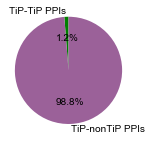

In [42]:
# draw pi chart for brain-2 for fraction TiP-TiP and TiP-any PPIs
index = tissue_order.index('brain-2')
labels = ['TiP-TiP PPIs','TiP-nonTiP PPIs']
sizes = [num_TiP_TiP_PPI_list[index],num_TiP_PPI_list[index] - num_TiP_TiP_PPI_list[index]]
explode = [0,0]
colors = ['green',(155/255, 97/255, 153/255)]

plt.figure(figsize=(2,2))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', colors=colors, shadow=False, startangle=90)
ax1 = plt.gca()
ax1.axis('equal')

plt.tight_layout()
outfile = '{}/{}_fracTiP_TiP_PPI_pie_chart_brain-2'.\
        format(figure_path,network_name)
plt.savefig(outfile + '.pdf',format='pdf',dpi=300)
plt.savefig(outfile + '.png',format='png',dpi=300)

plt.show()

In [2]:
# draw the distribution and real observation for nl and asp and a given tissue
real_nl = 11
real_asp = 2.1085271317829459

infile_asp = config.analysis_path + 'HI-III/GTExv6_NT_HI-III_TiPgenes_2.0_asp_rand_results.txt'
infile_nl = config.analysis_path + 'HI-III/GTExv6_NT_HI-III_TiPgenes_2.0_nl_rand_results.txt'

df = pandas.read_table(infile_nl)
plt.figure(figsize=(2.7,2.3))
plt.hist(df.iloc[:,0],bins=16,color="lightgrey",edgecolor='black')
plt.xlabel('Number TiP-TiP PPIs',fontsize=12)
plt.ylabel('Number of\nrandom networks',fontsize=12)
ax = plt.gca()
ylim = ax.get_ylim()
xlim = ax.get_xlim()
x = xlim[1] - xlim[0]
y = ylim[1] - ylim[0]
plt.arrow(real_nl,y/4.0,0,y/7.0*(-1),color='red',head_width=x/30.0,head_length=y/20.0,linewidth=2)
plt.tight_layout()
outfile = figure_path + 'brain_other_nl_rand_distr'
plt.savefig(outfile + '.pdf',format='pdf',dpi=300)
outfile = figure_path + 'brain_other_nl_rand_distr'
plt.savefig(outfile + '.png',format='png',dpi=300)
plt.show()

df = pandas.read_table(infile_asp)
plt.figure(figsize=(2.7,2.3))
plt.hist(df.iloc[:,0],bins=16,color="lightgrey",edgecolor='black')
plt.xlabel('Average shortest path',fontsize=12)
plt.ylabel('Number of\nrandom networks',fontsize=12)
ax = plt.gca()
ylim = ax.get_ylim()
xlim = ax.get_xlim()
x = xlim[1] - xlim[0]
y = ylim[1] - ylim[0]
plt.arrow(real_asp,y/4.0,0,y/7.0*(-1),color='red',head_width=x/30.0,head_length=y/20.0,linewidth=2)
plt.tight_layout()
outfile = figure_path + 'brain_other_asp_rand_distr'
plt.savefig(outfile + '.pdf',format='pdf',dpi=300)
outfile = figure_path + 'brain_other_asp_rand_distr'
plt.savefig(outfile + '.png',format='png',dpi=300)
plt.show()

FileNotFoundError: [Errno 2] File b'../data/katjas_data/GTEx/analysis_GTExV6_2018_frozen/HI-III/GTExv6_NT_HI-III_TiPgenes_2.0_nl_rand_results.txt' does not exist: b'../data/katjas_data/GTEx/analysis_GTExV6_2018_frozen/HI-III/GTExv6_NT_HI-III_TiPgenes_2.0_nl_rand_results.txt'

In [31]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7.0
mpl.rcParams['savefig.dpi'] = 500
comma_fmt = matplotlib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x)))

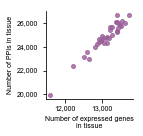

In [36]:
num_edges = []
num_expr_genes = []
for tissue in GTEx_tissues:
    num_edges.append(len(CSNs[tissue].es))
    num_expr_genes.append(GTEx.loc[GTEx[tissue] > 5,].shape[0])
    
plt.figure(figsize=(2,1.9))
plt.plot(num_expr_genes,num_edges,marker='.',markersize=8,alpha=0.8,color=(155/255, 97/255, 153/255),linestyle='')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_major_formatter(comma_fmt)
ax.xaxis.set_major_formatter(comma_fmt)
plt.xlabel('Number of expressed genes\nin tissue')
plt.ylabel('Number of PPIs in tissue')
plt.tight_layout()
outfile = figure_path + '/expr_genes_vs_edges_in_tissue'
plt.savefig(outfile + '.pdf',format='pdf',dpi=300)
plt.savefig(outfile + '.png',format='png',dpi=300)
plt.show()